# 1. import the necessery libraries


In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate



# 2. load and split the data 

In [2]:
import os 
import numpy as np 
import pandas as pd 
import imageio 
import matplotlib.pyplot as plt 
%matplotlib inline 

path =''
image_path = os.path.join(path,'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/')
mask_path = os.path.join(path,'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]
image_list = sorted(image_list)
mask_list = sorted(mask_list)

print("number of images is : {} ".format(len(image_list)))

print(image_list[0])
print(mask_list[0])

number of images is : 400 
../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/000.jpg
../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/000.png


# 3. explore some images :

(4000, 6000, 3)
(4000, 6000)


Text(0.5, 1.0, 'Mask')

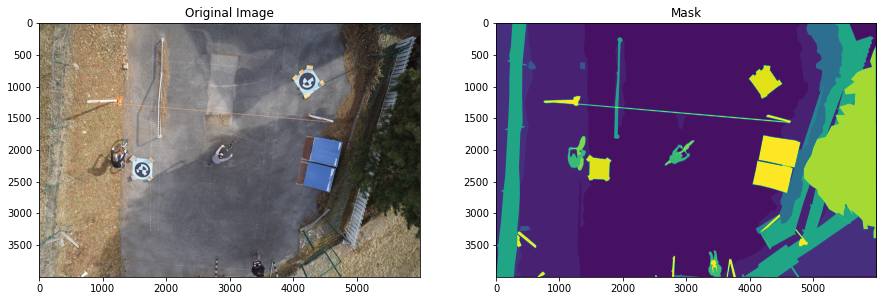

In [3]:
n = 10 # you can chose any index 
img  = imageio.imread(image_list[n])
print(img.shape)
mask = imageio.imread(mask_list[n])
print(mask.shape)

# now let's plot 
fig ,arr  = plt.subplots(1,2,figsize=(15,10))
arr[0].imshow(img)
arr[0].set_title('Original Image')
arr[1].imshow(mask)
arr[1].set_title('Mask')

In [4]:
image_list_dataset = tf.data.Dataset.list_files(image_list ,shuffle=False)
mask_list_dataset = tf.data.Dataset.list_files(mask_list , shuffle=False)
images_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((images_filenames
                                              ,masks_filenames))
for image,mask in dataset.take(1) : 
    print(image)
    print(mask)

tf.Tensor(b'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/000.jpg', shape=(), dtype=string)
tf.Tensor(b'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/000.png', shape=(), dtype=string)


2021-10-17 12:56:51.245711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-17 12:56:51.356021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-17 12:56:51.357104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-17 12:56:51.360752: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# 4. preprocessing our data

In [5]:
def process_path(image_path,mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img,channels=3)
    img = tf.image.convert_image_dtype(img,tf.float32) #this do the same as dividing by 255 to set the values between 0 and 1 (normalization)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask,channels=3)
    mask = tf.math.reduce_max(mask,axis=-1,keepdims=True)
    return img , mask

def preprocess(image,mask) : 
    input_image = tf.image.resize(image,(96,128),method='nearest')
    input_mask = tf.image.resize(mask,(96,128),method='nearest')
    
    return input_image , input_mask

image_ds = dataset.map(process_path) # apply the preprocces_path function to our dataset
print(image_ds)
processed_image_ds = image_ds.map(preprocess) # apply the preprocess function to our dataset

<MapDataset shapes: ((None, None, 3), (None, None, 1)), types: (tf.float32, tf.uint8)>


# 5.  Define The Conv Block For The Contracting Path


In [6]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)
   
    

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

# 6. Define the upsampling block for the expanding path

In [7]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    
    return conv

# 7. Finally! ,  we will Define the unet model 
## which composes of a set of conv blocks and upsampling blocks

In [8]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    
    inputs = Input(input_size)
    
    #contracting path
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3) 
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.3, max_pooling=None)     
    
    #expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [9]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

# 1. Our model is ready !!

In [10]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 128, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 128, 32)  9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [11]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
EPOCHS = 150
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 16
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/150


2021-10-17 12:56:57.410716: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-17 12:57:08.327385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 13 of 500
2021-10-17 12:57:18.110915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 27 of 500
2021-10-17 12:57:28.061188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 41 of 500
2021-10-17 12:57:38.185615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 55 of 500
2021-10-17 12:57:49.044239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 71 of 500
2021-10-17 12:57:58.545030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buff

25/25 [==============================] - 287s 42ms/step - loss: 2.4691 - accuracy: 0.3288
Epoch 2/150
25/25 [==============================] - 1s 41ms/step - loss: 2.0564 - accuracy: 0.3818
Epoch 3/150
25/25 [==============================] - 1s 41ms/step - loss: 1.8000 - accuracy: 0.4922
Epoch 4/150
25/25 [==============================] - 1s 42ms/step - loss: 1.6861 - accuracy: 0.5213
Epoch 5/150
25/25 [==============================] - 1s 43ms/step - loss: 1.5267 - accuracy: 0.5582
Epoch 6/150
25/25 [==============================] - 1s 41ms/step - loss: 1.5104 - accuracy: 0.5612
Epoch 7/150
25/25 [==============================] - 1s 41ms/step - loss: 1.4178 - accuracy: 0.5815
Epoch 8/150
25/25 [==============================] - 1s 41ms/step - loss: 1.3312 - accuracy: 0.6082
Epoch 9/150
25/25 [==============================] - 1s 42ms/step - loss: 1.2923 - accuracy: 0.6175
Epoch 10/150
25/25 [==============================] - 1s 41ms/step - loss: 1.3006 - accuracy: 0.6152
Epoch 11/

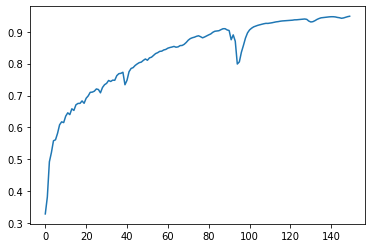

In [13]:
plt.plot(model_history.history["accuracy"])

In [14]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [15]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [16]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

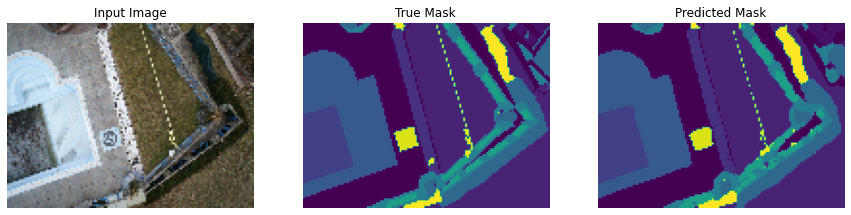

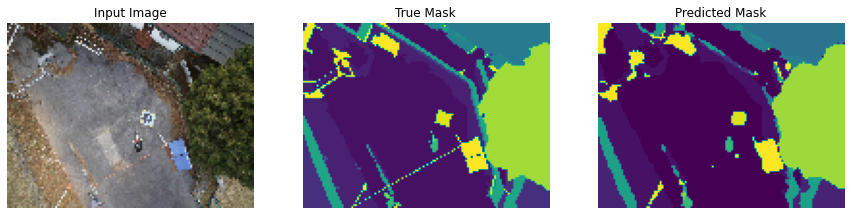

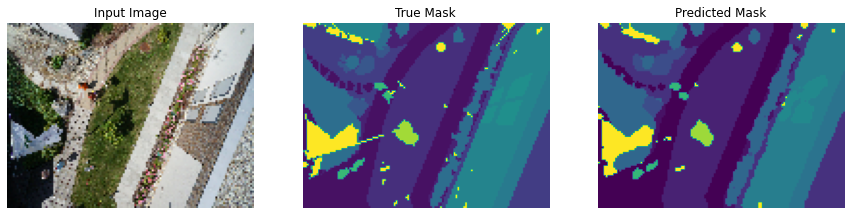

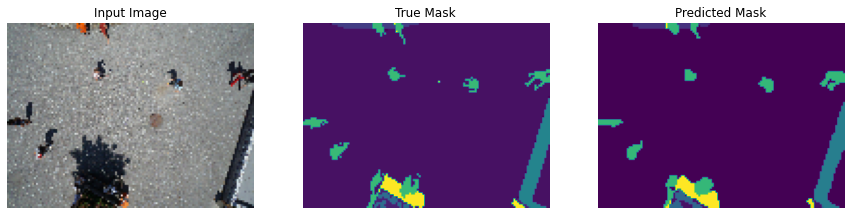

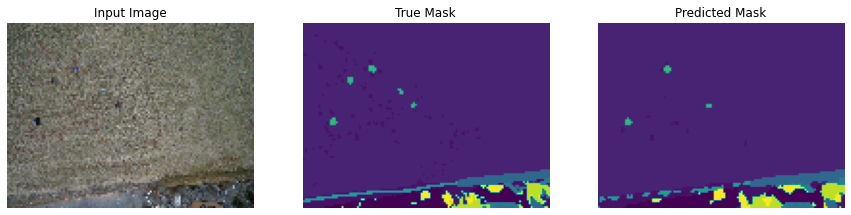

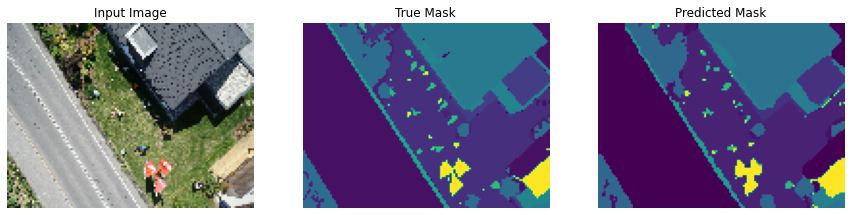

In [17]:
show_predictions(train_dataset, 6)